## mask_galaxies

A script that makes a mask for the EAGLE simulation based on the location of galaxies from the galaxy catalogue.

The size of the mask is based on the half-mass radius given in the galaxy catalogue.

The script takes in a data file from the EAGLE simulation, xystarts (the lower left x,y position relative to the full EAGLE simulation), slicewidth (in order to determine the z range), and the size of the simulation. 

In [6]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology
from skimage import morphology as skimagemorphology

import get_halpha_SB

import eagleSqlTools as sql

%matplotlib inline

In [4]:
%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'

In [5]:
machine = 'chinook'

In [23]:
def pltimg(data_FOV,xystarts,size,ax=None):
    if ax is None:
        fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
    colmap = 'viridis'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("top",size="5%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

def pltcutout(data_FOV,xystarts,size,ax=None):
    xpixsize,ypixsize = data_FOV.shape
    xlength,ylength = size
    midx=xpixsize/2; midy=ypixsize/2
    boxlength = 1. #Mpc
    pixsizex=xpixsize/xlength*boxlength
    data_cutout = data_FOV[midx-pixsizex/2:midx+pixsizex/2,midy-pixsizex/2:midy+pixsizex/2]
        
    xystarts_x = xystarts[0] + (midx-pixsizex/2)/(xpixsize/xlength)
    xystarts_y = xystarts[1] + (midy-pixsizex/2)/(ypixsize/ylength)
    size_new = [boxlength,boxlength]

    pltimg(data_cutout,[xystarts_x,xystarts_y],size_new,ax=ax)
    
def plotgals(xgal,ygal,rhgas,rhstar,mgal,ax1,verbose):
    for i in range(len(xgal)):
        colour = 'green'
        if mgal[i]>10**8:
            colour = 'yellow'
        if mgal[i]>10**9:
            colour = 'orange'
        if mgal[i]>10**10:
            colour = 'red'
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhgas[i]/1000., color=colour,fill=False)
        ax1.add_artist(circle1)
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhstar[i]/1000., color='blue',fill=False)
        ax1.add_artist(circle1)
        if verbose:
            Mpcperpix = 0.477/1000.*(1.+0.0235) * 6.4
            if (rhstar[i]*5.) > (Mpcperpix*1000.) and (rhgas[i]*5.) > (Mpcperpix*1000.):
                print("5*rhstar, %.1f, is greater than %s kpc, and has galaxy mass of %s, and a 5*rhgas of %.1f."%\
                      ((rhstar[i]*5.),(Mpcperpix*1000.),mgal[i],(rhgas[i]*5.)))
                circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhstar[i]/1000.*5., color='purple',fill=False)
                ax1.add_artist(circle1)

    
def getbounds(data_FOV, xystarts, size, slicewidth):
    """
    Reads in the output from extract_FOV and spits out the bounds of the cutout data in Mpc
    Also takes in the slicewidth, so that it can output bound in the z-direction
    """
    xmin = xystarts[0]; xmax = xystarts[0]+size[0]; ymin = xystarts[1]; ymax = xystarts[1]+size[1]  # Mpc
    zmin = 0.; zmax = float(slicewidth)
    # We have to add weird numbers because when I loaded the data, the simulations were out of order...
    if int(slicewidth)==5:
        zmin = zmin+10.; zmax = zmax+10.
    if int(slicewidth)==10:
        zmin = zmin+10.; zmax = zmax+10.
    if int(slicewidth)==15:
        zmin = zmin+5.; zmax = zmax+5.
        
    return xmin,xmax,ymin,ymax,zmin,zmax

def searchgals(xmin,xmax,ymin,ymax,zmin,zmax,verbose):
    
    mySim = ('RefL0100N1504',100.)
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s and \
                SH.MassType_Star > 0 "%('RefL0100N1504',xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    #z = myData['CentreOfMass_z'][:]
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    
    return xgal,ygal,mgal,rhgas,rhstar

def makemask(xgal,ygal,rhstar,rhgas,mgal,data,xystarts,size,distance,resolution,debug=False,verbose=False):
    pixscale =  {'46Mpc': 0.221/1000.*(1.+0.0107), '50Mpc': 0.237/1000.*(1.+0.0115), \
                 '92Mpc': 0.437/1000.*(1.+0.0215),'100Mpc': 0.477/1000.*(1.+0.0235),\
                 '200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12)} ### Mpc / arcsec (comoving)
    xsize = data.shape[0]; ysize = data.shape[1]
    xlen = size[0]; ylen = size[1]
    Mpcperpix = pixscale[distance]*resolution
    if debug:
        print xsize,ysize
        print xlen,ylen
        print Mpcperpix
    bordersize = 10
    mask = np.zeros((xsize+2*bordersize,ysize+2*bordersize))
    if debug:
        print mask.shape
    for i in range(len(xgal)):
        xind = int(round((xgal[i]-xystarts[0])*xsize/xlen))
        yind = int(round((ygal[i]-xystarts[1])*ysize/ylen))
        xmask = xind+10; ymask = yind+10
        mask[xmask,ymask] = 1
        if (rhstar[i]*5.) > (Mpcperpix*1000.) and (rhgas[i]*5.) > (Mpcperpix*1000.):
            if verbose:
                print("5*rhstar, %.1f, is greater than %s kpc, has galaxy mass of %s, a 5*rhgas of %.1f."%\
                              ((rhstar[i]*5.),(Mpcperpix*1000.),mgal[i],(rhgas[i]*5.)))
            five_rhstar = rhstar[i]*5.
            radpix = int( round( five_rhstar/(Mpcperpix*1000.) ) ) - 1 # -1 because adds center pixel
            piecemask = skimagemorphology.disk(radpix) 
            if debug:
                print piecemask.shape
                print mask[xmask-radpix:xmask+radpix+1,ymask-radpix:ymask+radpix+1].shape
                print ""
            mask[xmask-radpix:xmask+radpix+1,ymask-radpix:ymask+radpix+1] = piecemask

    mask = mask[bordersize+1:xsize+bordersize+1,bordersize+1:ysize+bordersize+1]
    if debug:
        print mask.shape

    masked_data = np.ma.masked_array(data, mask=mask)
    
    return masked_data

def maskgalaxies(data_FOV,xystarts,size,slicewidth,distance,resolution,debug=True,verbose=True,showplots=True):
    'check that the right things have been inputted'
    if data_FOV.shape[1]==0 or data_FOV.shape[0]==0:
        print "Wrong inputs! The input data array must be a 2darray with side lengths greater than zero "
        return None
    if len(xystarts)!=2 or len(size)!=2:
        print "Wrong inputs! The xystarts and size must both be 1darrays with 2 entries."
        return None
    
    if showplots:
        'Take a look at the input data_FOV'
        pltimg(data_FOV,xystarts,size)
    
    'Get the x, y, and z ranges for querying the galaxy catalogue'
    xmin,xmax,ymin,ymax,zmin,zmax = getbounds(data_FOV, xystarts, size, slicewidth)
    'Search the EAGLE catalogue for all the galaxies within it and return some of their parameters.'
    xgal,ygal,mgal,rhgas,rhstar = searchgals(xmin,xmax,ymin,ymax,zmin,zmax,verbose)
    'Transform coordinates of galaxy catalogue into coordinate system with origin at (0,0) position of the cutout.'
    xgal_zero = xgal-xmin
    ygal_zero = ygal-ymin
    
    if showplots:
        'Take a look at whether the cutout and the galaxy catalogue match up'
        fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
        pltimg(data_FOV,xystarts,size,ax=ax)
        plotgals(xgal,ygal,rhgas,rhstar,mgal,ax,verbose)
        
        #pltimg(data_FOV,[0,0],size,ax=ax)
        #plotgals(xgal_zero,ygal_zero,rhgas,rhstar,mgal,ax,verbose)    
    
    'Mask the data based on the galaxy locations and sizes'
    masked_data = makemask(xgal,ygal,rhstar,rhgas,mgal,data_FOV,xystarts,size,distance,resolution,debug=debug,verbose=verbose)
    
    if showplots:
        'Take a look at the data and the mask together (make it about a 1Mpc/1Mpc size)'
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
        pltcutout(masked_data.mask,xystarts,size,ax=ax1)
        pltcutout(masked_data.data,xystarts,size,ax=ax2)
        
    return masked_data

### Testing maskgalaxies

In [37]:
slicewidth = 20.; resolution = None; distance   = '100Mpc';
data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 100Mpc is 6.40094057981.
Loading data of slicewidth 20 (after rounding), number of slices is 4
./intermediatedata/data_100Mpc_6arcsec_20slwd.npz does not exist, making it now...
Data exists, loading ./intermediatedata/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_zcen12.5_total.npz now...
Reducing the resolution to desired distance/resolution...
Will reduce resolution by a factor of 1.0.
DEBUGGING: data_tuple is: 
(array([[-2.62077141, -2.62564492, -2.63008714, ..., -2.60400987,
        -2.60988569, -2.61549926],
       [-2.61682892, -2.62165141, -2.62603831, ..., -2.60022902,
        -2.60604405, -2.61160588],
       [-2.61321568, -2.6179862 , -2.62232232, ..., -2.59680223,
        -2.60254669, -2.60804701],
       ..., 
       [-2.63436723, -2.63937879, -2.64398909, ..., -2.61722207,
        -2.62324262, -2.62897563],
       [-2.62957692, -2.63454533, -2.63909

In [38]:
resolution = 6.4 ### PUT THIS IN MANUALLY FROM THE OUTPUT OF data_tuple
data_tuple[0].shape

(32000, 32000)

In [39]:
data_FOV, xystarts, size = extractFOV(data_tuple,resolution,distance,x_center=50.5,y_center=13.5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


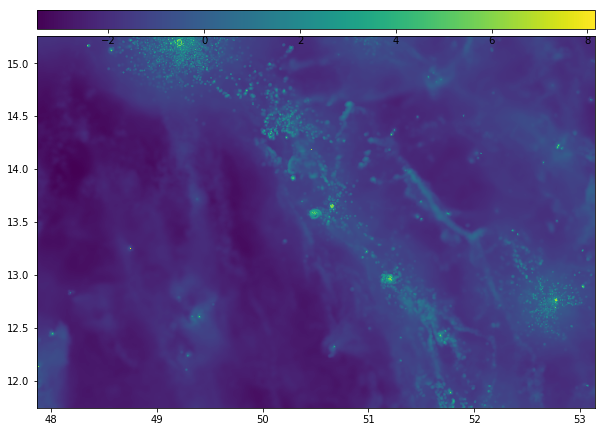

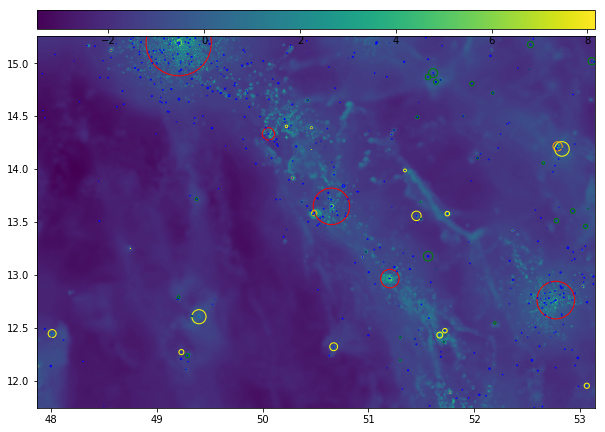

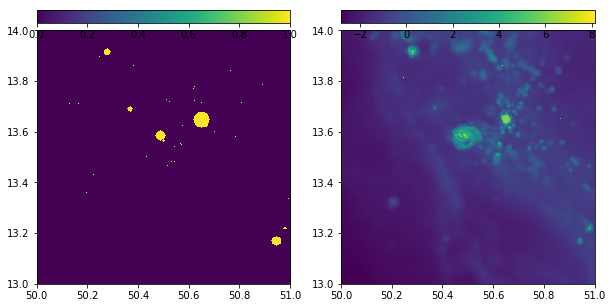

In [40]:
masked_data = maskgalaxies(data_FOV,xystarts,size,slicewidth,distance,resolution,debug=False,verbose=False)

In [41]:
data_FOV.shape

(1688, 1124)

In [42]:
def imreduce_masked(img,factor,mask=None,log=True,fillby='max'):
    """
    reduces the resolution of an image by taking the mean of individual elements
    takes in a mask to mask out values to be not included in the mean
        img: 2D image array
        mask: mask for the 2D image array
        factor: factor by which to reduce the number of array elements along each axis
        log: whether or not the array contains log data values
    examples:
    for testing: 
        image = np.array([[1,1,2,2],[1,201,2,2],[3,3,200,4],[3,3,4,4]])
    mask your mask like this:  
        clipped = sigma_clip(image,sig=3,iters=2)
        mask = clipped.mask
    """
    if log:
        inimg = 10**img
    else:
        inimg = img
    
    inshape = np.array(img.shape)
    
    if mask is None:
        clipped_full = sigma_clip(inimg,sig=3,iters=5)
        outliers =clipped_full.mask
        # grow the mask
        outliers =morphology.grey_dilation(outliers,(3,3))       # the mask
        print "the mask:"
        print outliers
        print "saving as imreduce_mask.npz..."
        np.savez('imreduce_mask.npz',outliers)
        inmask = outliers
    else:
        outliers = mask
        inmask = mask
        
    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None

    # split along axes into groups that will be binned
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    # do the same for the masks
    inmask = np.array(np.split(inmask,inshape[0]/factor,axis=0))
    inmask = np.array(np.split(inmask,inshape[1]/factor,axis=-1))
    
    # make the masked array
    x = np.ma.array(inimg, mask=inmask)
       
    # take the mean along different axes
    x = np.ma.mean(x,axis=-1)
    x = np.ma.mean(x,axis=-1)
    
    # BUT WHAT IF THERE IS ONLY MASKED DATA WITHIN A BIN...
    fillvalue=fillby
    if True in x.mask:
        print "WARNING: At least one bin contains only masked data - will be filled to %s."%fillby
        if fillby=='min':
            x = x.filled(x.min())
            fillvalue= x.min()
        elif fillby=='mean':
            x = x.filled(x.mean())
            fillvalue= x.mean()
        elif fillby=='max':
            x = x.filled(x.max())
            fillvalue=x.max()
        else:
            x = x.filled(fillvalue)
        #return x.T,outliers,fillvalue
        outimg = x
    else:
        outimg = x.data
    
    if log:
        outimg = np.log10(outimg)
    
    return outimg.T, outliers, fillvalue

In [43]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

In [44]:
finalres = 30.
factor = finalres/resolution
xsize,ysize = mask_data.data.shape
xsize/factor

#finalres = 30.
#factor = round(finalres/resolution)
#'If the factors are not integer multiples of the size, trim the data first and then imreduce it'
#if size%((factor)) != 0.:
#    times_factor_fits_in = int(size/factor)
#    newsize = times_factor_fits_in * factor
#    print("Before reducing resolution, the original data was trimmed to size %s."%newsize)
#    datanew = data[0:int(newsize),0:int(newsize)]
 

NameError: name 'mask_data' is not defined

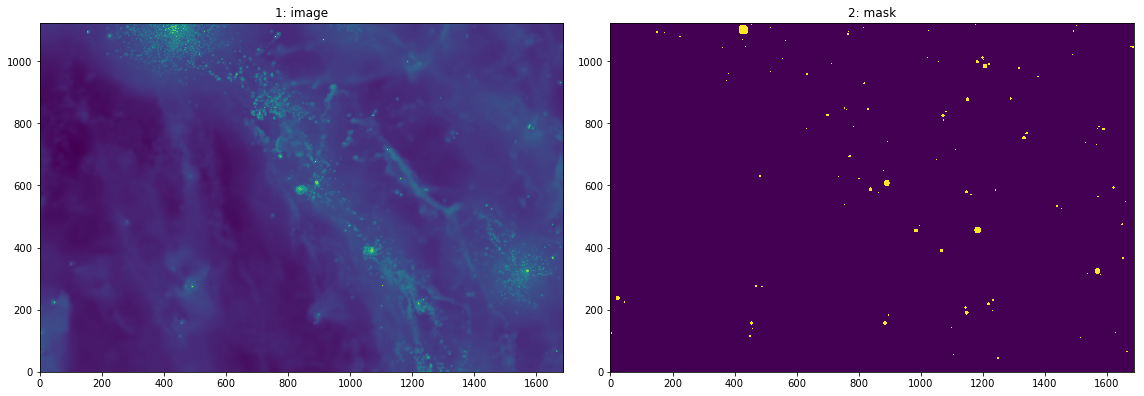

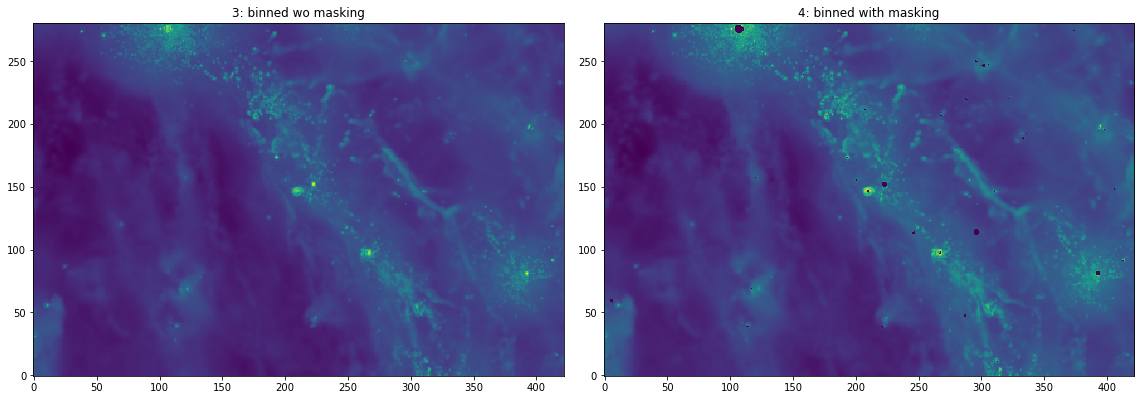

In [45]:
# Plot the full res data and mask of that
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(masked_data.data.T,ax=ax1)
ax1.set_title('1: image')
plotdata(masked_data.mask.T,ax=ax2)
ax2.set_title('2: mask')
plt.tight_layout()
   
factor = 4

# Plot the binned data (wo mask) and binned data (w mask)
lowres = get_halpha_SB.imreduce(masked_data.data, factor, log=False, method = 'average') 
lowres_masked, mask, fillvalue = imreduce_masked(masked_data.data,factor,mask=masked_data.mask,log=False,fillby='min')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(lowres.T,ax=ax1)
ax1.set_title('3: binned wo masking')
plotdata(lowres_masked.T,ax=ax2)
ax2.set_title('4: binned with masking')
plt.tight_layout()